In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [91]:
# Load the dataset
csv_file = "/content/Car_Monitoring_Data.csv"
df = pd.read_csv(csv_file)

# Convert the Timestamp to a datetime object
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

<ipython-input-91-60f68b8ab37c>:6: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


In [92]:
# Data Preprocessing
features = ['Oxygen', 'CO2', 'CO', 'Methane', 'Temperature']
df['Alarm Triggered'] = df['Alarm Triggered'].astype(int)  # Convert boolean column to integer


In [93]:
# Normalize features
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)
df_scaled['Timestamp'] = df['Timestamp']
df_scaled['Alarm Triggered'] = df['Alarm Triggered']

In [94]:

# Step 3: Build Hybrid Model (LSTM + GAN) (Optional for Advanced Use Case)

# Generator Model
def build_generator(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(128)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(X_train.shape[1] * X_train.shape[2], activation='tanh')(x)
    generator_output = x
    generator = Model(inputs=input_layer, outputs=generator_output)
    return generator

# Discriminator Model
def build_discriminator(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(256)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    discriminator_output = x
    discriminator = Model(inputs=input_layer, outputs=discriminator_output)
    return discriminator

In [95]:
# LSTM Model for Classification
def build_lstm_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    lstm_branch = LSTM(50, return_sequences=True)(input_layer)
    lstm_branch = LSTM(50)(lstm_branch)
    output_layer = Dense(1, activation='sigmoid')(lstm_branch)
    lstm_model = Model(inputs=input_layer, outputs=output_layer)
    return lstm_model

In [96]:
# Hybrid Model
generator = build_generator(input_dim=100)
discriminator = build_discriminator(input_shape=(X_train.shape[1] * X_train.shape[2],))
lstm_classifier = build_lstm_classifier(input_shape=(X_train.shape[1], X_train.shape[2]))

# Compile the GAN
input_noise = Input(shape=(100,))
fake_data = generator(input_noise)
discriminator.trainable = False
validity = discriminator(fake_data)
combined_gan = Model(inputs=input_noise, outputs=validity)
combined_gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
lstm_classifier.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [97]:
# Compile the GAN
input_noise = Input(shape=(100,))
fake_data = generator(input_noise)
discriminator.trainable = False
validity = discriminator(fake_data)
combined_gan = Model(inputs=input_noise, outputs=validity)
combined_gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
lstm_classifier.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [99]:
# Prediction using LSTM
SEQ_LENGTH = 10  # Sequence length for LSTM

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [100]:
# Prepare the data
oxygen_values = df['Oxygen'].values.reshape(-1, 1)
oxygen_normalized = scaler.fit_transform(oxygen_values)

X, y = create_sequences(oxygen_normalized, SEQ_LENGTH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [110]:
# Train the model
history = model.fit(X_train, y_train, epochs=43, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 2/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 3/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014 - val_loss: 0.0053
Epoch 4/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 5/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.5530e-04 - val_loss: 0.0031
Epoch 6/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 7/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 8/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 9/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 10/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 11/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0010 - val_loss: 0.0035
Epoch 12/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss:

In [102]:
# Evaluate the model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Root Mean Squared Error (RMSE): 0.20


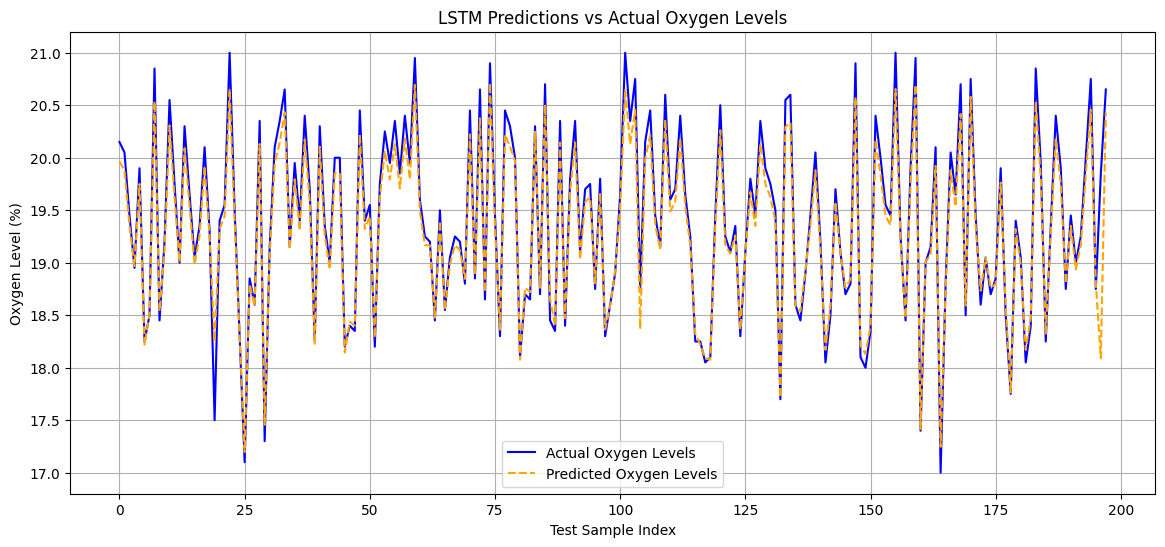

In [103]:
# Visualization of Predictions
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label="Actual Oxygen Levels", color='blue')
plt.plot(predictions, label="Predicted Oxygen Levels", color='orange', linestyle='--')
plt.title('LSTM Predictions vs Actual Oxygen Levels')
plt.xlabel('Test Sample Index')
plt.ylabel('Oxygen Level (%)')
plt.legend()
plt.grid(True)
plt.show()

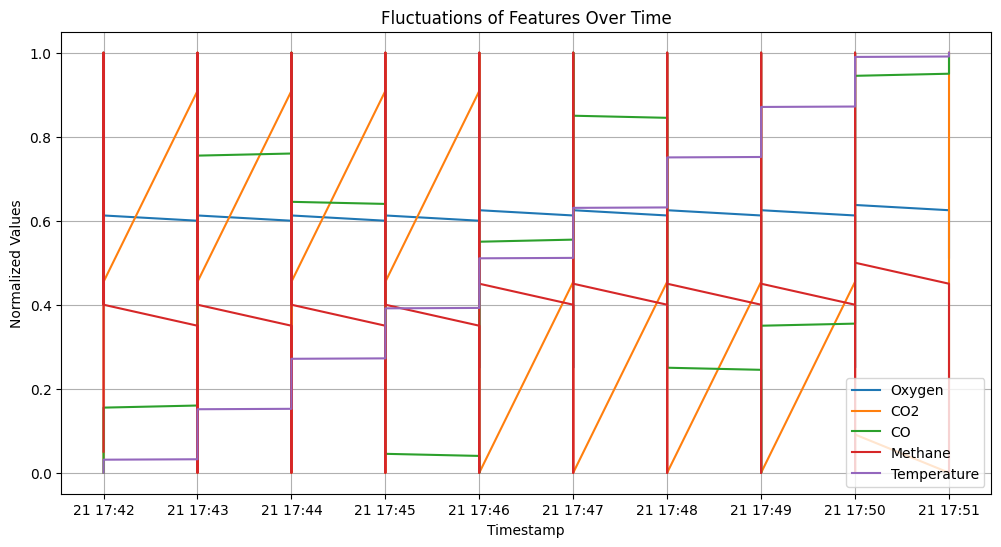

In [104]:
# Visualizations
plt.figure(figsize=(12, 6))
for feature in features:
    plt.plot(df_scaled['Timestamp'], df_scaled[feature], label=feature)
plt.title('Fluctuations of Features Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Normalized Values')
plt.legend()
plt.grid(True)
plt.show()

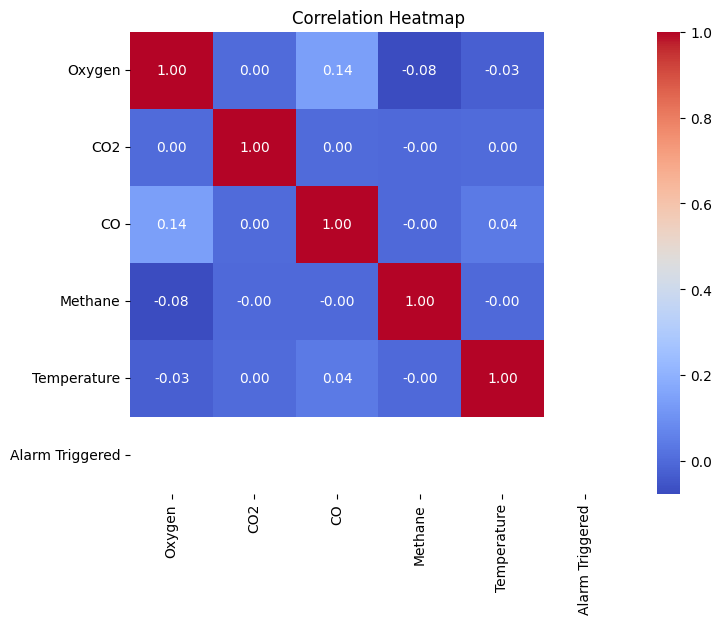

In [105]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[features + ['Alarm Triggered']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


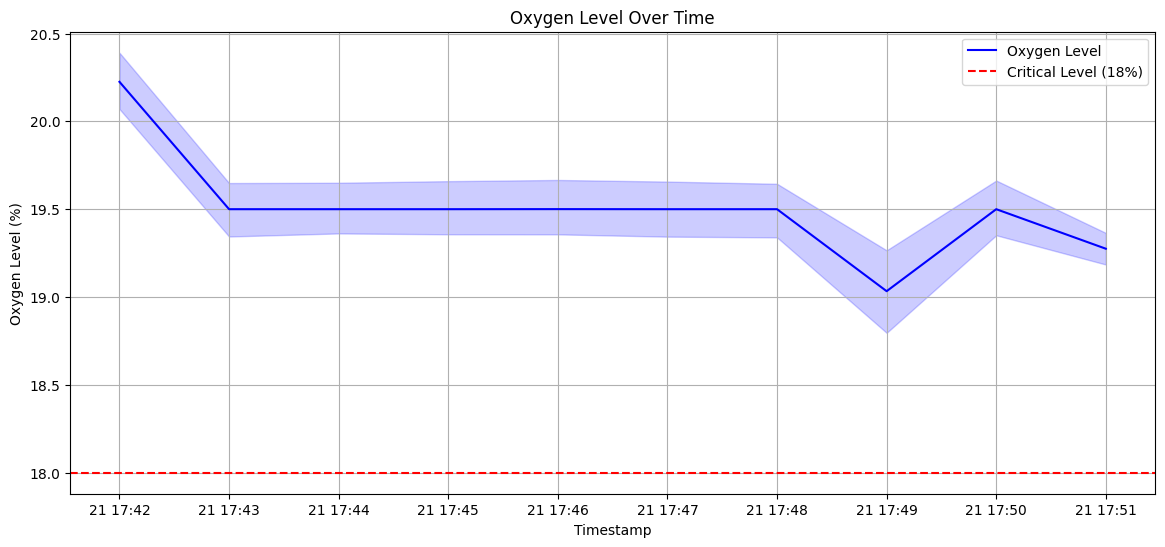

In [106]:
# Oxygen Level vs Time (Advanced Graph)
plt.figure(figsize=(14, 6))
sns.lineplot(x='Timestamp', y='Oxygen', data=df, label='Oxygen Level', color='blue')
plt.axhline(y=18, color='red', linestyle='--', label='Critical Level (18%)')
plt.title('Oxygen Level Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Oxygen Level (%)')
plt.legend()
plt.grid(True)
plt.show()


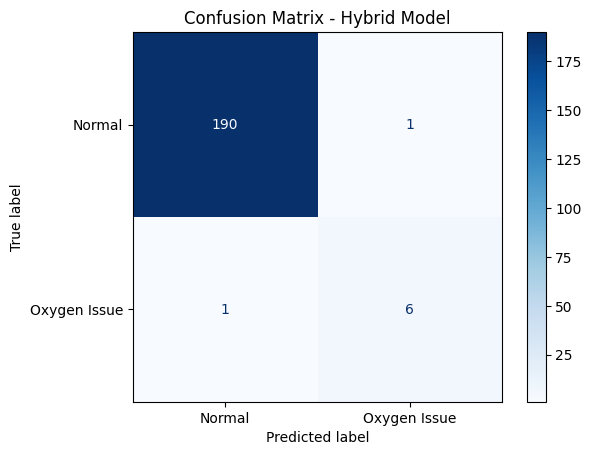

In [107]:
# Confusion Matrix
cm = confusion_matrix(y_test_cls, y_pred_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Oxygen Issue"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Hybrid Model")
plt.grid(False)
plt.show()


In [108]:

# Classification Report
print("\nClassification Report for Hybrid Model:\n")
print(classification_report(y_test_cls, y_pred_cls))


Classification Report for Hybrid Model:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       191
           1       0.86      0.86      0.86         7

    accuracy                           0.99       198
   macro avg       0.93      0.93      0.93       198
weighted avg       0.99      0.99      0.99       198



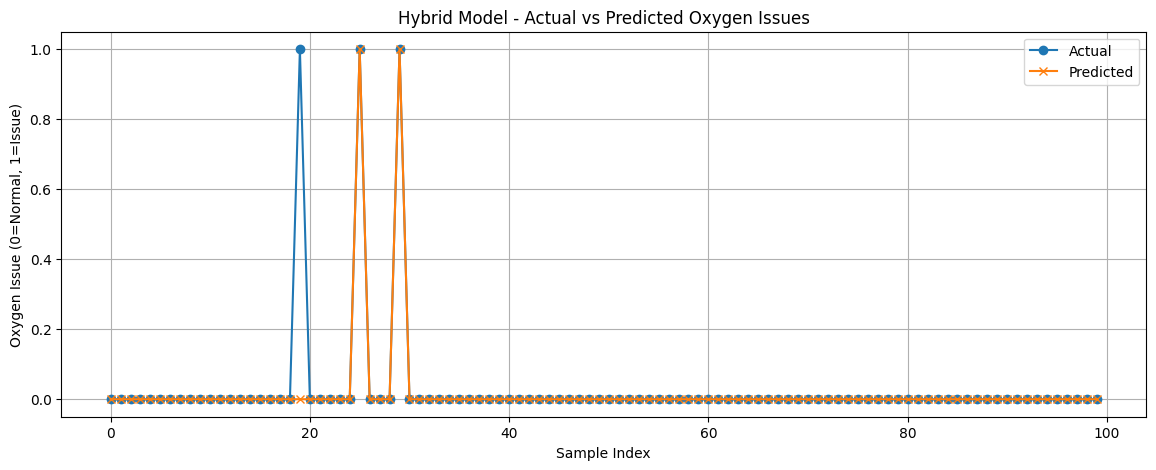

In [109]:
# Plot Actual vs Predicted
plt.figure(figsize=(14, 5))
plt.plot(y_test_cls[:100], label='Actual', marker='o')
plt.plot(y_pred_cls[:100], label='Predicted', marker='x')
plt.title('Hybrid Model - Actual vs Predicted Oxygen Issues')
plt.xlabel('Sample Index')
plt.ylabel('Oxygen Issue (0=Normal, 1=Issue)')
plt.legend()
plt.grid(True)
plt.show()
